In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



In [2]:
seed=42

In [3]:
infile = './processed/CLARITY_Export_2021-01-28_222148_min15_max45.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)
df.head()

,15,20,25,30,35,40,45,Low
5,0.309038,0.311953,0.276968,0.276968,0.276968,0.276968,0.276968,0.0
6,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.233236,0.0
7,0.309038,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.0
8,0.309038,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.0
9,0.309038,0.311953,0.276968,0.233236,0.183673,0.183673,0.183673,0.0


In [7]:
df['Low'].value_counts()

0.0    24961
1.0     1886
Name: Low, dtype: int64

Classes imablanced (25000+ 0 / Not Low vs 1886 1 / Low), so try SMOTE Over and Undersampling

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [10]:
sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

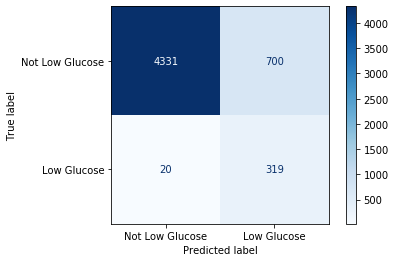

In [11]:
model = LogisticRegression().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


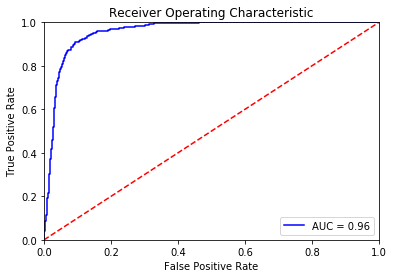

In [12]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

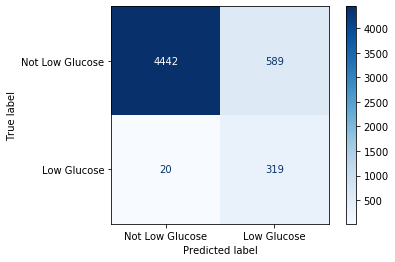

In [13]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(res_x, res_y)

disp = plot_confusion_matrix(clf, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


Undersample the majority class

In [14]:
low = df[df['Low'] == 1.0]
not_low = df[df['Low'] == 0.0].sample(n = 1292, random_state=seed)

df_us = low.append(not_low)

In [15]:
### Train on undersampled set
train, test = train_test_split(df_us, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,0:-1]
test_y = test.iloc[:,-1]


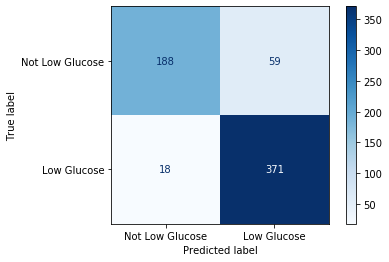

In [16]:
model = LogisticRegression().fit(train_x, train_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


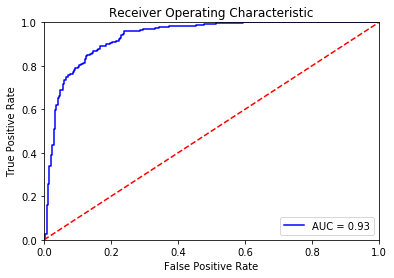

In [17]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Repeat but on different time interval

In [20]:
infile = './processed/CLARITY_Export_2021-01-28_222148_min30_max60.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)
df.head()

,30,35,40,45,50,55,60,Low
9,0.309038,0.311953,0.311953,0.311953,0.311953,0.311953,0.311953,0.0
10,0.309038,0.311953,0.276968,0.233236,0.183673,0.183673,0.183673,0.0
11,0.309038,0.311953,0.276968,0.233236,0.183673,0.163265,0.163265,0.0
12,0.309038,0.311953,0.276968,0.233236,0.183673,0.163265,0.128280,0.0
13,0.311953,0.233236,0.183673,0.163265,0.128280,0.259475,0.259475,0.0


In [21]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [22]:
sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

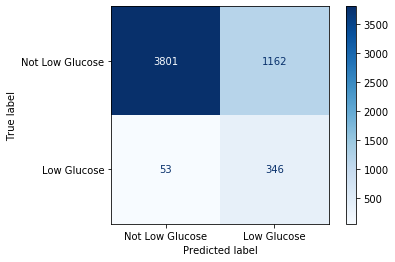

In [23]:
model = LogisticRegression().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

False positive rate is much worse when extrapolate lows when using data that are further back in time. Need to determine what an appropriate cutoff is.

What if we use a longer time interval for extrapolation?

In [3]:
infile = './processed/CLARITY_Export_2021-03-01_min15_max60.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)
df.tail()

,15,20,25,30,35,40,45,50,55,60,Low
26854,-0.510934,-0.510934,-0.510934,-0.510934,-0.510934,-2.840286,-2.840286,-2.840286,-2.840286,-2.840286,0.0
26855,0.294770,0.294770,-0.045081,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,0.0
26856,0.294770,0.294770,0.294770,-0.045081,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,0.0
26857,0.294770,0.294770,0.294770,0.294770,-0.045081,-0.300523,-0.300523,-0.300523,-0.300523,-0.300523,0.0
26858,1.010631,1.010631,0.294770,0.294770,0.294770,-0.045081,-0.300523,-0.300523,-0.300523,-0.300523,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000279F9FB8888>]],
      dtype=object)

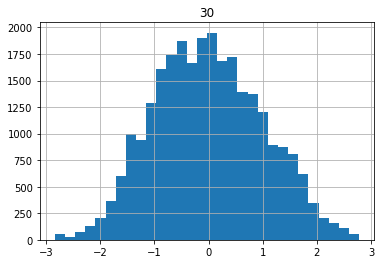

In [48]:
df.hist(column='30', bins=30)

In [49]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [50]:
sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

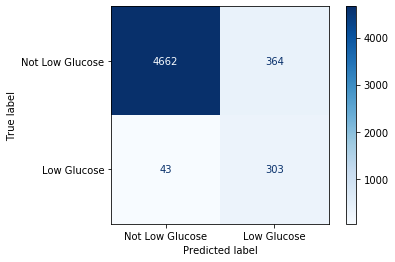

In [51]:
model = RandomForestClassifier(min_samples_leaf=20).fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

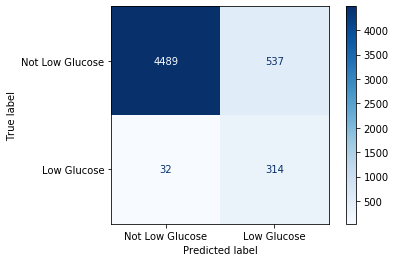

In [52]:
model = LogisticRegression().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

What causes the high false positive rate?

First guess: maybe duplicated/interpolated values 

In [53]:
def get_pred_rows(test_y, preds, df):
    
    idxs = test_y.iloc[preds > 0.5].index ### positive predictions (i.e., Low predictions)

    return df.iloc[idxs]

In [54]:
df_positive = get_pred_rows(test_y, preds, df)

C:\Users\Josh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000279F87A6808>,
      dtype=object)

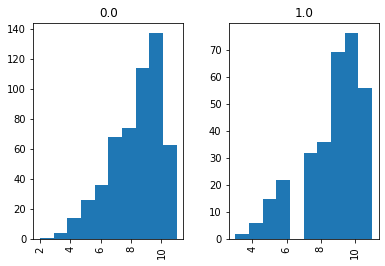

In [55]:
try:
    df_positive.drop(columns='num_uniq', inplace=True)
    df_positive['num_uniq'] = df_positive.apply(pd.Series.nunique, axis=1)
except KeyError:
    df_positive['num_uniq'] = df_positive.apply(pd.Series.nunique, axis=1)

    
df_positive.tail()
df_positive.hist(column='num_uniq', by='Low')

1.0
15   -1.309473
20   -1.210584
25   -1.115475
30   -1.084563
35   -1.146776
40   -1.276071
45   -1.594169
50   -2.003016
55   -2.285021
60   -2.093513
Name: 2050, dtype: float64
-1.6061394082191613


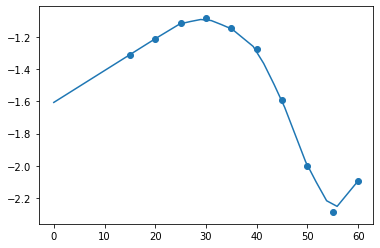

In [4]:
from scipy.interpolate import interp1d

ind = 2050
columns = df.columns[0:-1].astype(int)

print(df.iloc[ind, -1])
f = interp1d(columns, df.iloc[ind, 0:-1], kind='slinear', fill_value='extrapolate')
print(df.iloc[ind, 0:-1])
plt.scatter(columns, df.iloc[ind, 0:-1])
plt.plot(np.linspace(60, 0, 30), f(np.linspace(60, 0, 30)))
print(f(0))

In [5]:
infile = './processed/CLARITY_Export_2021-03-01_min15_max60_raw.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)


1.0
15    74.0
20    76.0
25    76.0
30    78.0
35    78.0
40    79.0
45    81.0
50    81.0
55    83.0
60    83.0
Name: 161, dtype: float64
68.0


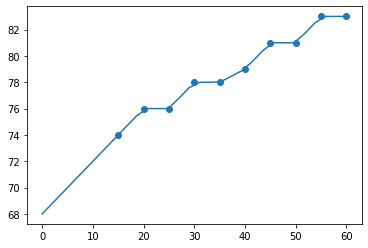

In [67]:
from scipy.interpolate import interp1d

ind = 161
columns = df.columns[0:-1].astype(int)

print(df.iloc[ind, -1])
f = interp1d(columns, df.iloc[ind, 0:-1], kind='slinear', fill_value='extrapolate')
print(df.iloc[ind, 0:-1])
plt.scatter(columns, df.iloc[ind, 0:-1])
plt.plot(np.linspace(60, 0, 30), f(np.linspace(60, 0, 30)))
print(f(0))

In [54]:
from scipy.interpolate import interp1d

def interp_glucose(times, values, kind='slinear'):
    
    f = interp1d(times, values, kind=kind, fill_value='extrapolate')
    return f(0)

In [57]:
preds = []
columns = df.columns[0:-1].astype(int)

for i in range(df.shape[0]):
    pred = interp_glucose(columns, df.iloc[i, 0:-1], kind='slinear')
    if pred <= 70:
        preds.append(1.0)
    else:
        preds.append(0.0)

In [58]:
matching_1 = np.where( (preds == df["Low"]) & (df["Low"] == 1.0) )
print( 'True Positive Rate: {:.2f}'.format(len(matching_1[0]) / df[df["Low"] == 1.0].shape[0] ))

matching_0 = np.where( (preds == df["Low"]) & (df["Low"] == 0.0) )
print(  'True Negative Rate: {:.2f}'.format(len(matching_0[0]) / df[df["Low"] == 0.0].shape[0] ))

mismatch_fp = np.where( (preds != df["Low"]) & (df["Low"] == 0.0) )
print(  'False Positive Rate: {:.2f}'.format(len(mismatch_fp[0]) / df[df["Low"] == 0.0].shape[0] ))

mismatch_fn = np.where( (preds != df["Low"]) & (df["Low"] == 1.0) )
print(  'False Negative Rate: {:.2f}'.format(len(mismatch_fn[0]) / df[df["Low"] == 1.0].shape[0]) )

True Positive Rate: 0.76
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.24


In [38]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [39]:
sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

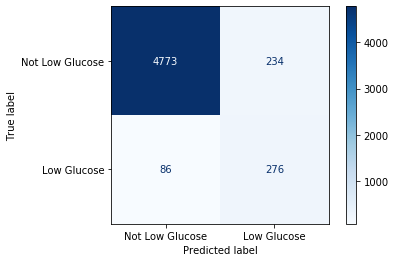

In [41]:
model = RandomForestClassifier().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

In [49]:
print( 'True Positive Rate: {:.2f}'.format(276 / (86 + 276)) )
print( 'True Negative Rate: {:.2f}'.format(4773 / (4773 + 234)) )
print( 'False Positive Rate: {:.2f}'.format(234 / (234 + 4773)) )
print( 'False Negative Rate: {:.2f}'.format(86 / (86 + 276)) )

True Positive Rate: 0.76
True Negative Rate: 0.95
False Positive Rate: 0.05
False Negative Rate: 0.24


In [62]:
low = df[df['Low'] == 1.0]
not_low = df[df['Low'] == 0.0].sample(n = low.shape[0], random_state=seed)

df_us = low.append(not_low)

In [68]:
train, test = train_test_split(df_us, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

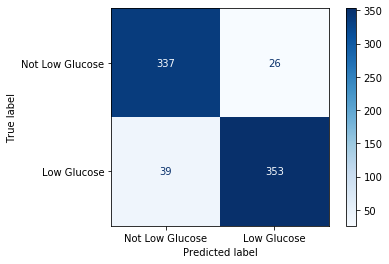

In [69]:
model = RandomForestClassifier().fit(train_x, train_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

In [74]:
train, test = train_test_split(df, test_size=0.5, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

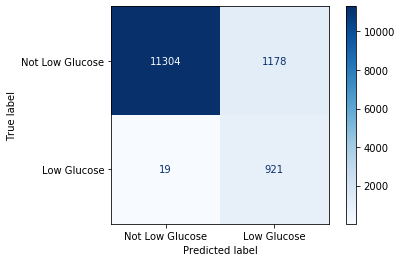

In [75]:
probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)